# Water Scarcity and Global Conflict Analysis
This project aims to explore the complex relationship between armed conflict and water scarcity by integrating and analyzing datasets from various sources. We will leverage geospatial and environmental data to assess how water scarcity influences the occurrence and intensity of conflicts.

## Hypothesis: Water is one of the most critical resources on the planet for human survival. When the demand for critical resources, such as water, exceeds the supply, the number of conflicts increases.

## Definitions
- Scarcity: Demand for a good or service is greater than the availability of the good or service (Oxford Languages).
- Supply: total freshwater resources available in cubic meters per person, per year (The ImpEE Project).
- Withdrawal: amount extracted for use by country (The ImpEE Project).
- Water Stress: ratio between total freshwater withdrawn (TFWW) and total renewable freshwater resources (TRWR). Water stress = TFWW / TRWR (Wikipedia).
- Water Scarcity: volume of fresh water available does not meet the per person per day recommendations for human health (University of Nottingham).er day

In [39]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import stats
from scipy.stats import pearsonr
from functools import partial, reduce

### Collect csv files

In [40]:
# Collect water scarcity data from the Food and Agriculture Organization (FAO) https://data.apps.fao.org/aquastat/?lang=en
aqua_csv = pd.read_csv('Resources/AQUASTAT Dissemination System.csv')

# Collect international conflict data from the University of Alabama https://internationalconflict.ua.edu/data-download/
mie_csv = pd.read_csv('Resources/ua-mie-1.0.csv')
micnames = pd.read_csv('Resources/ua-micnames-1.0.csv')

# Collect country codes from Correlates of War (COW) https://correlatesofwar.org/data-sets/cow-country-codes-2/
COW_Country_Codes = pd.read_csv('Resources/COW-country-codes.csv')

# Collect political regime type data from Out World in Data https://ourworldindata.org/grapher/political-regime-fh
regimes_csv = pd.read_csv('Resources/political-regime-fh.csv')

# Collect per capita income by country from Our World in Data https://ourworldindata.org/grapher/gdp-per-capita-worldbank
per_capita_income_csv = pd.read_csv('Resources/gdp-per-capita-worldbank.csv')

### Cleanup the Militarized Interstate Events (MIE) csv file

In [41]:
# Copy the dataframe with only the columns we want 
mie_df = mie_csv[['styear', 'ccode1', 'eventnum', 'micnum', 'hostlev', 'ccode2']].copy()

# Create a dictionary for the country codes and their names and the confrontation codes and their name
code_to_country = pd.Series(COW_Country_Codes.StateNme.values, index=COW_Country_Codes.CCode).to_dict()
conflict_name = pd.Series(micnames.micname.values, index= micnames.micnum).to_dict()

# Map the country codes to their names from the dictionary and replace
mie_df['ccode1'] = mie_df['ccode1'].map(code_to_country)
mie_df['ccode2'] = mie_df['ccode2'].map(code_to_country)

# Rename columns headers
mie_df = mie_df.rename(columns={'styear': 'Year',
                                'ccode1': 'Country',
                                'ccode2': 'Target Country',
                                'eventnum': 'Event Number',
                                'micnum': 'Number_of_Conflicts',
                                'hostlev': 'Hostility Level'
                                })
# Display the clean dataframe
mie_df

,Year,Country,Event Number,Number_of_Conflicts,Hostility Level,Target Country
0,1902,United States of America,1,2,3,United Kingdom
1,1913,Austria-Hungary,1,3,2,Yugoslavia
2,1946,Albania,2,4,4,United Kingdom
3,1946,United Kingdom,3,4,3,Albania
4,1946,United Kingdom,4,4,3,Albania
...,...,...,...,...,...,...
28006,1859,Peru,1,9946,3,Ecuador
28007,1859,Peru,2,9946,4,Ecuador
28008,1975,Cambodia,1,9947,4,Vietnam
28009,1975,Vietnam,2,9947,4,Cambodia


### Conflicts per year for each country

In [42]:
# Filter for years between 1980 and 2015
filtered_year_df = mie_df[(mie_df['Year'] >= 1980) & (mie_df['Year'] <= 2015)]

# If you want to filter for specific countries, e.g., 'USA' and 'Canada'
countries = mie_df['Country']
filtered_df = filtered_year_df[filtered_year_df['Country'].isin(countries)]

# Group by 'Year' and count unique 'Conflict Name' for each year
mie_per_year_df = filtered_df.groupby(['Year', 'Country'])['Number_of_Conflicts'].nunique().reset_index()

# Rename columns for clarity
#mie_per_year_df.columns = ['Year', 'Country', 'Number_of_Conflicts']

# Display the result
mie_per_year_df.head(10)

,Year,Country,Number_of_Conflicts
0,1980,Afghanistan,1
1,1980,Angola,1
2,1980,Argentina,1
3,1980,Canada,1
4,1980,Chile,1
5,1980,Colombia,1
6,1980,Cuba,2
7,1980,Democratic Republic of the Congo,1
8,1980,Egypt,1
9,1980,Ethiopia,1


In [43]:
total_conflicts_per_year_df = mie_per_year_df.groupby('Year')['Number_of_Conflicts'].sum().reset_index()

# Rename columns for clarity
total_conflicts_per_year_df.columns = ['Year', 'Total_Conflicts']

# Display the result
print("Total Conflicts per Year:\n", total_conflicts_per_year_df)

Total Conflicts per Year:
     Year  Total_Conflicts
0   1980               57
1   1981               51
2   1982               51
3   1983               69
4   1984               67
5   1985               54
6   1986               53
7   1987               66
8   1988               30
9   1989               28
10  1990               17
11  1991               32
12  1992               44
13  1993               79
14  1994               66
15  1995               68
16  1996               64
17  1997               64
18  1998               78
19  1999               87
20  2000               60
21  2001               74
22  2002               70
23  2003               73
24  2004               49
25  2005               58
26  2006               41
27  2007               35
28  2008               39
29  2009               32
30  2010               37
31  2011               97
32  2012               60
33  2013               70
34  2014               75


In [44]:
no_of_countries_by_year_df = filtered_df.groupby('Year')['Country'].nunique().reset_index()

no_of_countries_by_year_df.columns = ['Year', 'Number_of_Countries_in_Conflict']

no_of_countries_by_year_df

,Year,Number_of_Countries_in_Conflict
0,1980,41
1,1981,35
2,1982,36
3,1983,43
4,1984,44
5,1985,35
6,1986,33
7,1987,40
8,1988,20
9,1989,23


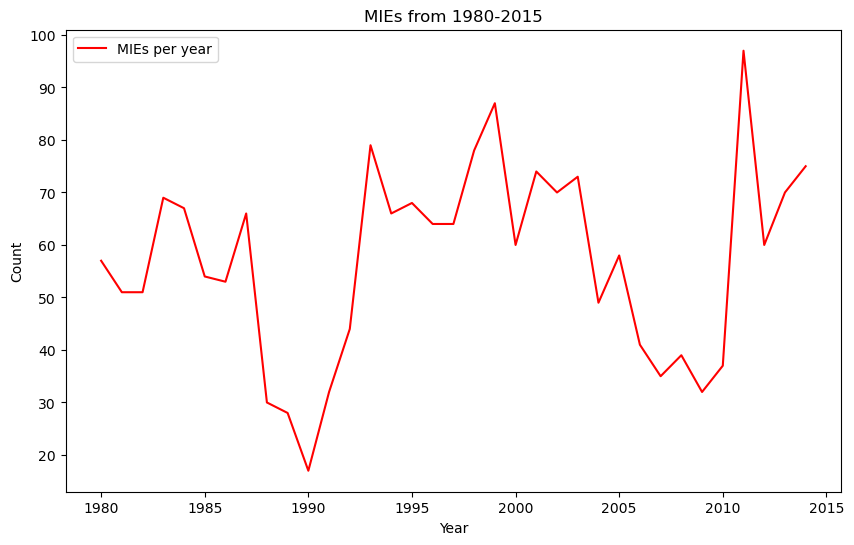

In [45]:
# Plot conflicts between 1980-2015
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red")
plt.title('MIEs from 1980-2015')
plt.xlabel('Year')
plt.ylabel('Count') 
plt.legend()
plt.show()

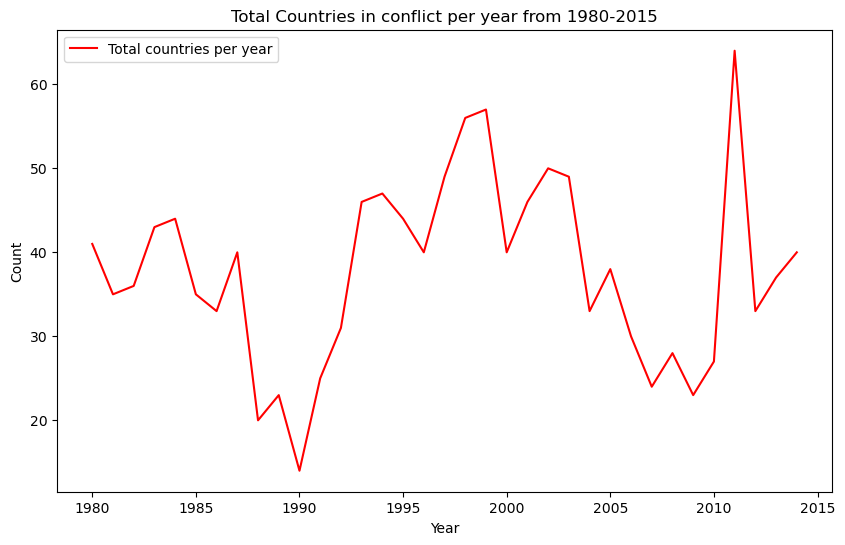

In [46]:
# Plot total countries in conflit per year between 1980-2015
plt.figure(figsize=(10, 6))
sns.lineplot(data=no_of_countries_by_year_df, x='Year', y='Number_of_Countries_in_Conflict', label='Total countries per year', color="red")
plt.title('Total Countries in conflict per year from 1980-2015')
plt.xlabel('Year')
plt.ylabel('Count') 
plt.legend()
plt.show()

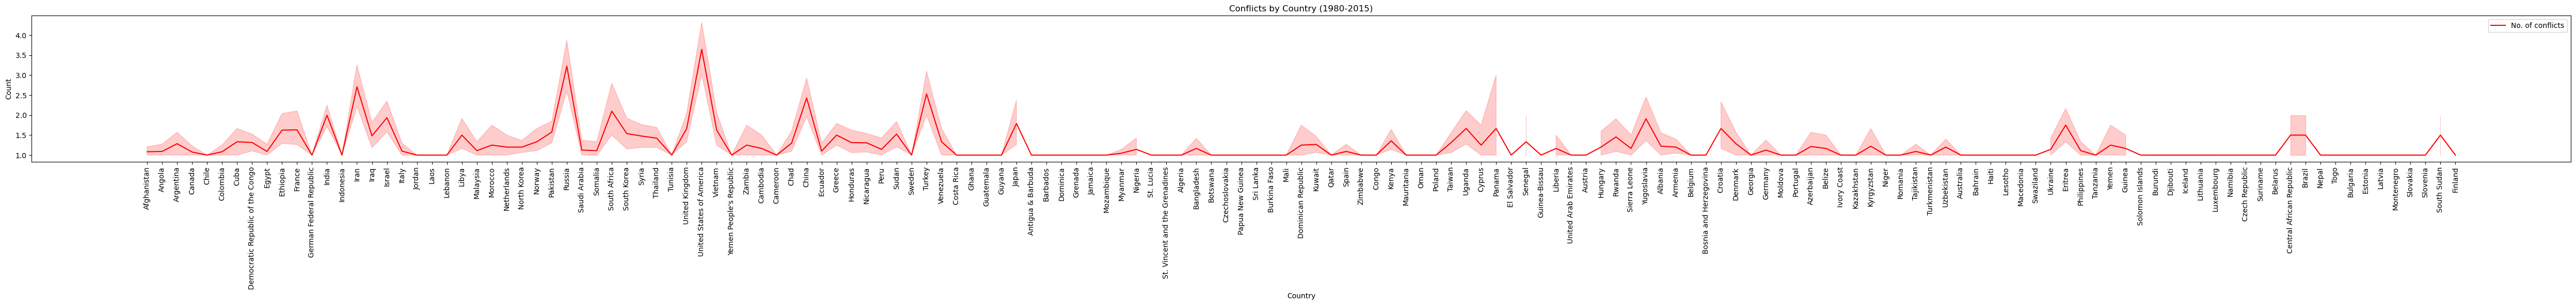

In [47]:
# Plot conflicts by country between 1980-2015
plt.figure(figsize=(50, 6))
sns.lineplot(data=mie_per_year_df, x='Country', y='Number_of_Conflicts', label='No. of conflicts', color="red")
plt.title('Conflicts by Country (1980-2015)')
plt.xlabel('Country')
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

### Cleanup Freedom Level of Countries csv

In [48]:
# Create dataframe for Freedom Level of Countries (0 - not free/1-partly free/2-free country)
# Drop code column
regimes_df = regimes_csv.drop(columns=["Code"])

# Rename Entity column to country
regimes_df = regimes_df.rename(columns={'Entity': 'Country',
                                        'Political regime': 'Freedom Level'})

# Replace country with dictionary values
regimes_df['Country'] = regimes_df['Country'].replace(code_to_country)

regimes_df.head()

,Country,Year,Freedom Level
0,Abkhazia,1997,0
1,Abkhazia,1998,0
2,Abkhazia,1999,0
3,Abkhazia,2000,0
4,Abkhazia,2001,0


### Cleanup Per Capita Income csv

In [49]:
# Create dataframe for Per Capita Income
# Drop code column
per_capita_df = per_capita_income_csv.drop(columns=["Code"])


# Rename GDP per capita column
per_capita_df = per_capita_df.rename(columns={'Entity': 'Country',
                                              'GDP per capita, PPP (constant 2017 international $)': 'Per Capita Income'})

# Replace country with dictionary values
per_capita_df['Country'] = per_capita_df['Country'].replace(code_to_country)

per_capita_df.head()

,Country,Year,Per Capita Income
0,Afghanistan,2002,1280.4631
1,Afghanistan,2003,1292.3335
2,Afghanistan,2004,1260.0605
3,Afghanistan,2005,1352.3207
4,Afghanistan,2006,1366.9932


### Water Stress Data Calculations and Visualizations

In [50]:
# Rename column header
aqua_csv = aqua_csv.rename(columns={'Area': 'Country'})

# Filter water stress data to include only the specific variable
water_df = pd.DataFrame(aqua_csv)
keyword = 'SDG 6.4.2. Water Stress'
filtered_water = aqua_csv['Variable'].str.contains(keyword, na=False)
filtered_water_df = water_df[filtered_water]
filtered_water_df.head()

,VariableGroup,Subgroup,Variable,Country,Year,Value,Unit,Symbol,IsAggregate
24124,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1975,28.887689,%,E,False
24125,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1976,32.354909,%,E,False
24126,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1977,35.822129,%,E,False
24127,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1978,39.289349,%,E,False
24128,Water use,Pressure on water resources,SDG 6.4.2. Water Stress,Afghanistan,1979,42.756569,%,E,False


In [51]:
#filter down to necessary columns
filtered_water_df = filtered_water_df[['Country', 'Year', 'Value', 'Unit']].copy()
filtered_water_df

,Country,Year,Value,Unit
24124,Afghanistan,1975,28.887689,%
24125,Afghanistan,1976,32.354909,%
24126,Afghanistan,1977,35.822129,%
24127,Afghanistan,1978,39.289349,%
24128,Afghanistan,1979,42.756569,%
...,...,...,...,...
59207,Zimbabwe,2017,31.346226,%
59208,Zimbabwe,2018,35.405385,%
59209,Zimbabwe,2019,39.769662,%
59210,Zimbabwe,2020,46.091620,%


In [52]:
# Find all rows where the Value is greater than 100
above_100_df = filtered_water_df[filtered_water_df['Value'] > 100]

# Display the rows
print(above_100_df)


       Country  Year       Value Unit
52851  Algeria  2009  102.435371    %
52852  Algeria  2010  104.920799    %
52853  Algeria  2011  107.406228    %
52854  Algeria  2012  109.750950    %
52855  Algeria  2013  115.163454    %
...        ...   ...         ...  ...
59142    Yemen  2017  169.761905    %
59143    Yemen  2018  169.761905    %
59144    Yemen  2019  169.761905    %
59145    Yemen  2020  169.761905    %
59146    Yemen  2021  169.761905    %

[575 rows x 4 columns]


In [53]:
#filter to between 1980 and 2015
filtered_water_by_year_df = filtered_water_df[(filtered_water_df['Year'] >= 1980) & (filtered_water_df['Year'] <= 2015)]

In [54]:
#Groupby year and value
overall_percentage_per_year = filtered_water_by_year_df.groupby('Year')['Value'].mean().reset_index()
print(overall_percentage_per_year)

    Year      Value
0   1980  54.169645
1   1981  57.192850
2   1982  59.129871
3   1983  62.086189
4   1984  64.124653
5   1985  61.485680
6   1986  62.858329
7   1987  46.081684
8   1988  47.134030
9   1989  48.748405
10  1990  47.181621
11  1991  46.741923
12  1992  50.126828
13  1993  60.287064
14  1994  59.184414
15  1995  58.233210
16  1996  59.448025
17  1997  60.913166
18  1998  62.181829
19  1999  63.756851
20  2000  57.600914
21  2001  57.602387
22  2002  57.641719
23  2003  58.144004
24  2004  59.985203
25  2005  61.400975
26  2006  61.219045
27  2007  61.089586
28  2008  60.754024
29  2009  60.928819
30  2010  61.006775
31  2011  61.330930
32  2012  61.656977
33  2013  61.945989
34  2014  62.189426
35  2015  62.645892


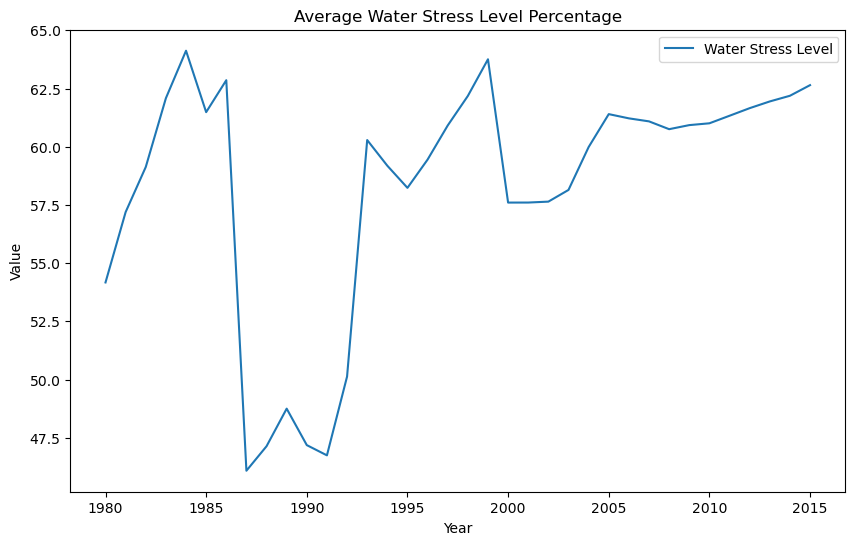

In [55]:
# Total Water Stress Level by year by average
plt.figure(figsize=(10, 6))
sns.lineplot(data=overall_percentage_per_year, x='Year', y='Value', label='Water Stress Level')
plt.title('Average Water Stress Level Percentage')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [56]:
total_value_per_year = filtered_water_by_year_df.groupby('Year')['Value'].sum().reset_index()
print(total_value_per_year)

    Year         Value
0   1980   2925.160817
1   1981   3088.413899
2   1982   3252.142902
3   1983   3414.740393
4   1984   3590.980563
5   1985   3750.626476
6   1986   3897.216413
7   1987   4101.269832
8   1988   4242.062680
9   1989   4387.356432
10  1990   4812.525321
11  1991   5048.127703
12  1992   6015.219326
13  1993   7777.031245
14  1994   7989.895941
15  1995   8210.882544
16  1996   8501.067554
17  1997   8771.495860
18  1998   9016.365135
19  1999   9308.500182
20  2000  10195.361808
21  2001  10310.827281
22  2002  10490.792892
23  2003  10640.352761
24  2004  11037.277393
25  2005  11420.581346
26  2006  11570.399467
27  2007  11668.110933
28  2008  11786.280595
29  2009  11820.190836
30  2010  11896.321054
31  2011  11959.531257
32  2012  12269.738402
33  2013  12327.251789
34  2014  12375.695695
35  2015  12466.532545


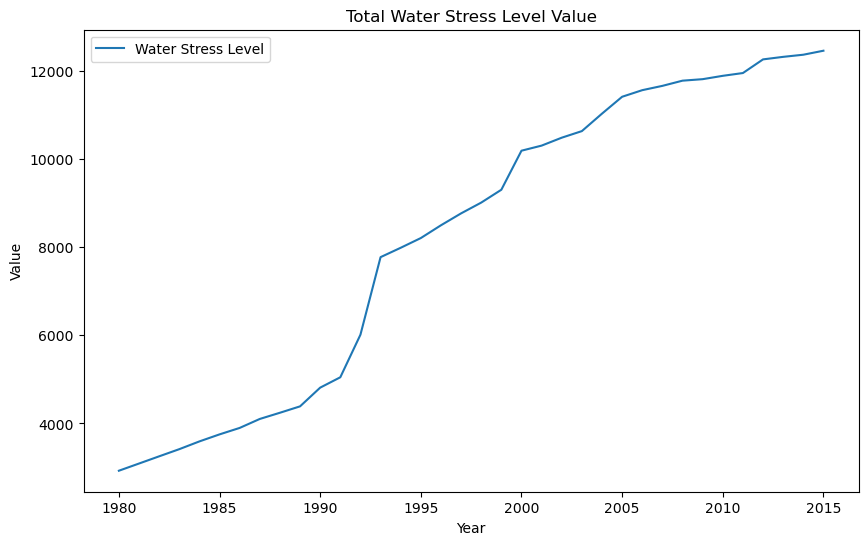

In [57]:
# Total Water Stress Level by year by sum
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_value_per_year, x='Year', y='Value', label='Water Stress Level')
plt.title('Total Water Stress Level Value')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [58]:
#Further filter water data by country and count total water stress per country between years 1980-2015
water_country_counts = filtered_water_by_year_df['Country'].value_counts().sort_index()
water_stress_per_country_df = pd.DataFrame({'Country': water_country_counts.index, 'Count': water_country_counts.values})
water_stress_per_country_df

,Country,Count
0,Afghanistan,36
1,Albania,26
2,Algeria,36
3,Angola,29
4,Antigua and Barbuda,26
...,...,...
194,Western Asia,16
195,World,16
196,Yemen,26
197,Zambia,24


In [59]:
overall_percentage_per_country_df = pd.DataFrame(filtered_water_by_year_df.groupby('Country')['Value'].mean().reset_index())
overall_percentage_per_country_df

,Country,Value
0,Afghanistan,57.742334
1,Albania,7.921158
2,Algeria,77.615184
3,Angola,1.673621
4,Antigua and Barbuda,7.433432
...,...,...
194,Western Asia,59.696875
195,World,17.894375
196,Yemen,160.847985
197,Zambia,2.905581


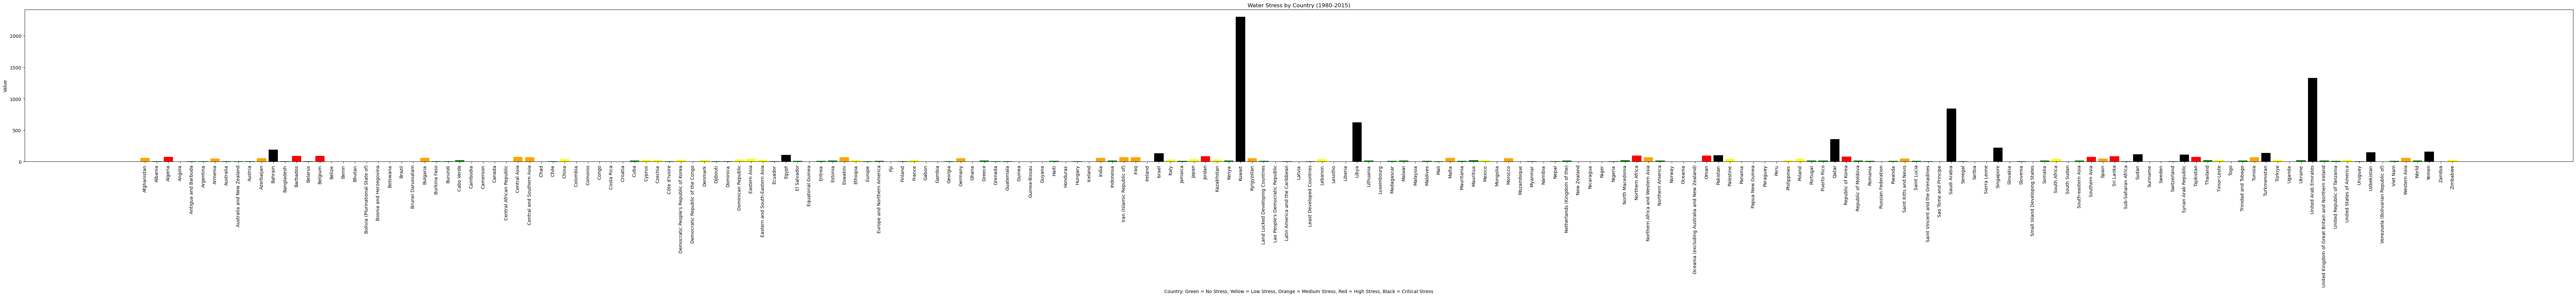

In [60]:
# Define conditions and corresponding colors
conditions = [
    (overall_percentage_per_country_df['Value'] <= 25),
    (overall_percentage_per_country_df['Value'] > 25) & (overall_percentage_per_country_df['Value'] <= 50),
    (overall_percentage_per_country_df['Value'] > 50) & (overall_percentage_per_country_df['Value'] <= 75),
    (overall_percentage_per_country_df['Value'] > 75) & (overall_percentage_per_country_df['Value'] <= 100)
]
colors = ['green', 'yellow', 'orange', 'red']

# Use np.select to assign colors based on conditions
overall_percentage_per_country_df['Color'] = np.select(conditions, colors, default='black')

# Plotting
fig, ax = plt.subplots(figsize=(100, 6))

# Plot bars manually
bars = ax.bar(overall_percentage_per_country_df['Country'], overall_percentage_per_country_df['Value'], color=overall_percentage_per_country_df['Color'])

# Add titles and labels
ax.set_title('Water Stress by Country (1980-2015)')
ax.set_xlabel('Country: Green = No Stress, Yellow = Low Stress, Orange = Medium Stress, Red = High Stress, Black = Critical Stress')
ax.set_ylabel('Value')
ax.tick_params(axis='x', labelrotation=90)

plt.show()

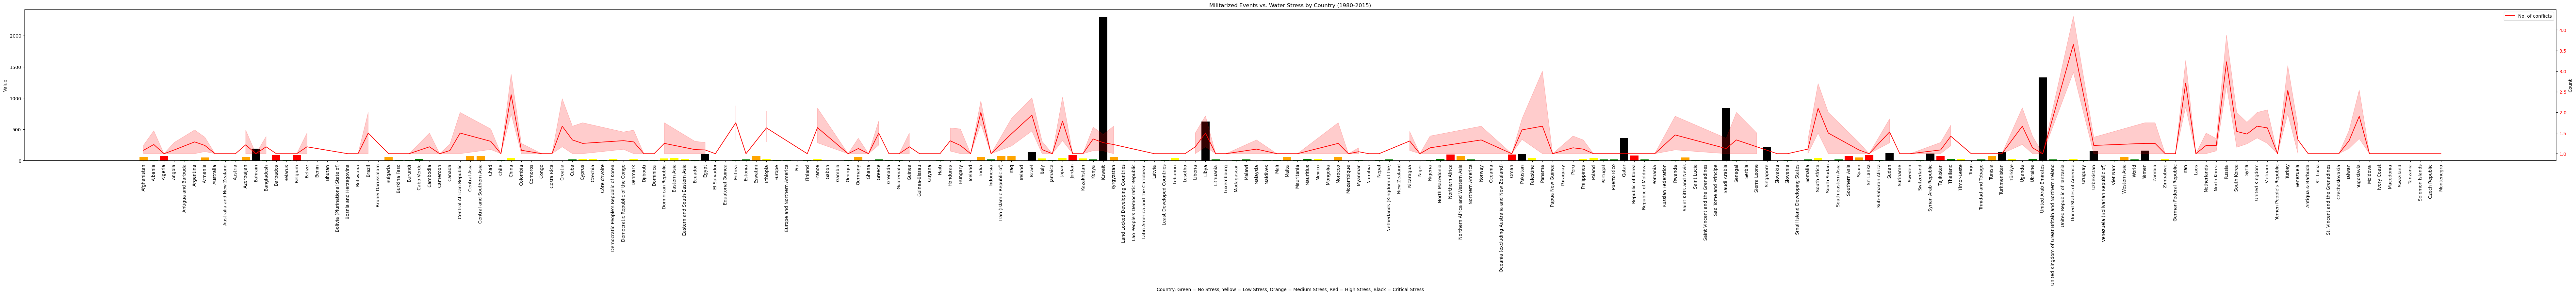

In [61]:
# Define conditions and corresponding colors
conditions = [
    (overall_percentage_per_country_df['Value'] <= 25),
    (overall_percentage_per_country_df['Value'] > 25) & (overall_percentage_per_country_df['Value'] <= 50),
    (overall_percentage_per_country_df['Value'] > 50) & (overall_percentage_per_country_df['Value'] <= 75),
    (overall_percentage_per_country_df['Value'] > 75) & (overall_percentage_per_country_df['Value'] <= 100)
]
colors = ['green', 'yellow', 'orange', 'red']

# Use np.select to assign colors based on conditions
overall_percentage_per_country_df['Color'] = np.select(conditions, colors, default='black')

# Plotting
fig, ax = plt.subplots(figsize=(100, 6))

# Plot bars manually
bars = ax.bar(overall_percentage_per_country_df['Country'], overall_percentage_per_country_df['Value'], color=overall_percentage_per_country_df['Color'])

# Add titles and labels
ax.set_title('Militarized Events vs. Water Stress by Country (1980-2015)')
ax.set_xlabel('Country: Green = No Stress, Yellow = Low Stress, Orange = Medium Stress, Red = High Stress, Black = Critical Stress')
ax.set_ylabel('Value')
ax.tick_params(axis='x', labelrotation=90)

ax2 = ax.twinx()

sns.lineplot(data=mie_per_year_df, x='Country', y='Number_of_Conflicts', label='No. of conflicts', color="red")
ax2.set_xlabel('Country')
ax2.set_ylabel('Count')
ax2.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='x', labelrotation=90)

#plt.savefig('militarized_events_vs_water_stress_by_country.png_color_coded.png', bbox_inches='tight') 
plt.show()

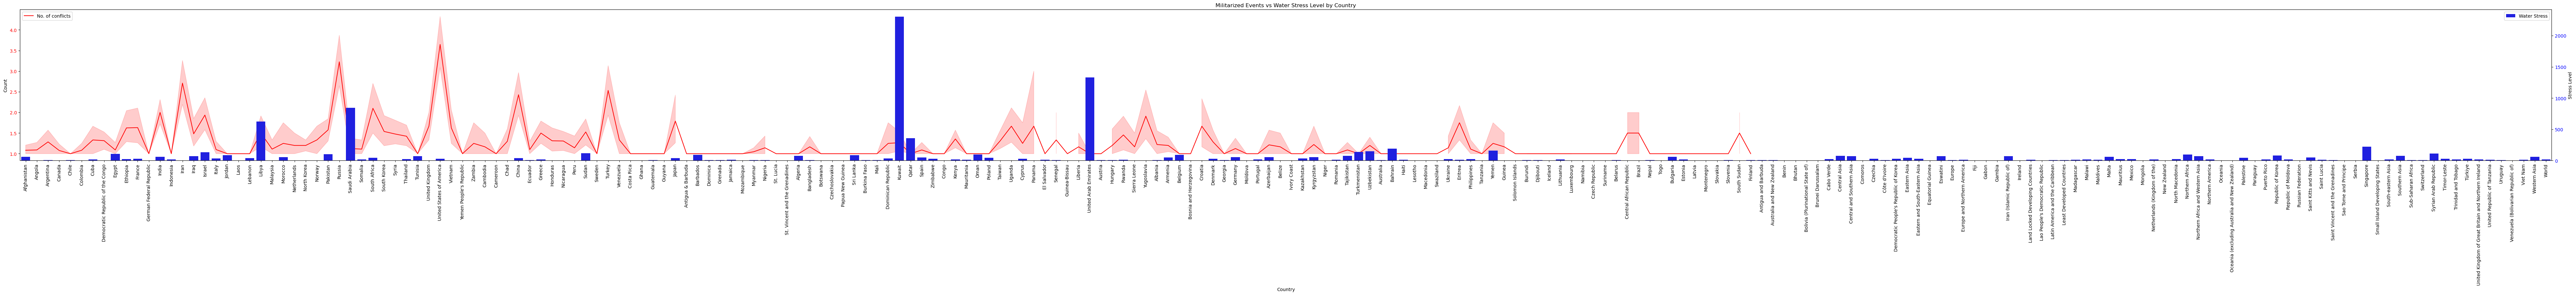

In [62]:
fig, ax1 = plt.subplots(figsize=(100, 6))
sns.lineplot(data=mie_per_year_df, x='Country', y='Number_of_Conflicts', label='No. of conflicts', color="red")
ax1.set_xlabel('Country')
ax1.set_ylabel('Count')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.barplot(data=overall_percentage_per_country_df, x='Country', y='Value', label='Water Stress', color="blue")
plt.xlabel('Country')
ax2.set_ylabel('Stress Level')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Militarized Events vs Water Stress Level by Country')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.tick_params(axis='x', labelrotation=90)

#plt.savefig('militarized_events_vs_water_stress_by_country.png', bbox_inches='tight') 
plt.show()

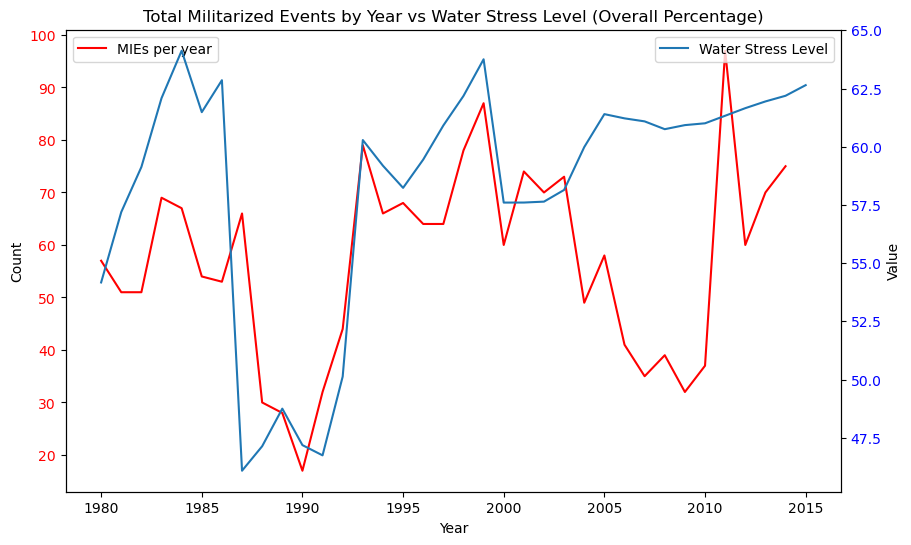

In [63]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red")
plt.title('MIEs from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=overall_percentage_per_year, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Total Militarized Events by Year vs Water Stress Level (Overall Percentage)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.savefig('militarized_events_vs_water_stress_by_year.png', bbox_inches='tight') 
plt.show()

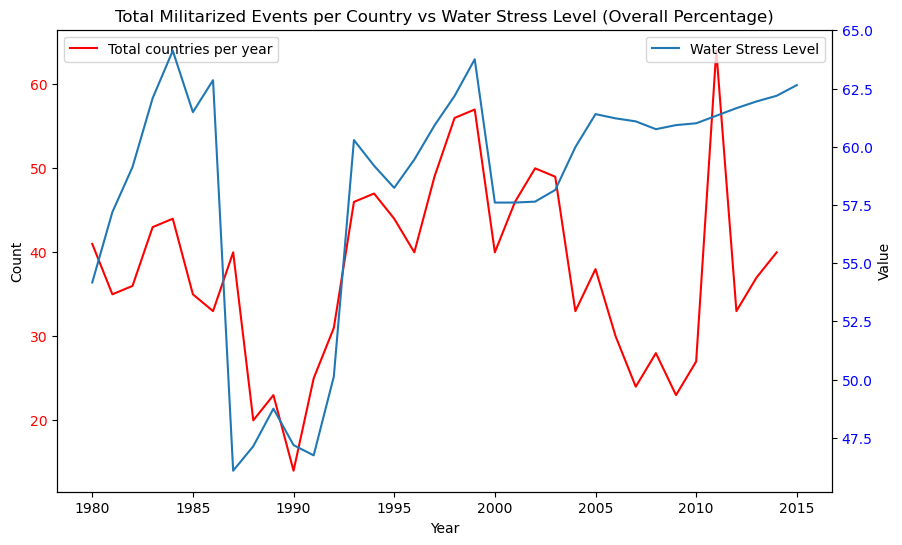

In [64]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=no_of_countries_by_year_df, x='Year', y='Number_of_Countries_in_Conflict', label='Total countries per year', color="red")
plt.title('Total Countries in conflict per year from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=overall_percentage_per_year, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Total Militarized Events per Country vs Water Stress Level (Overall Percentage)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.savefig('militarized_events_vs_water_stress_by_country.png', bbox_inches='tight') 
plt.show()


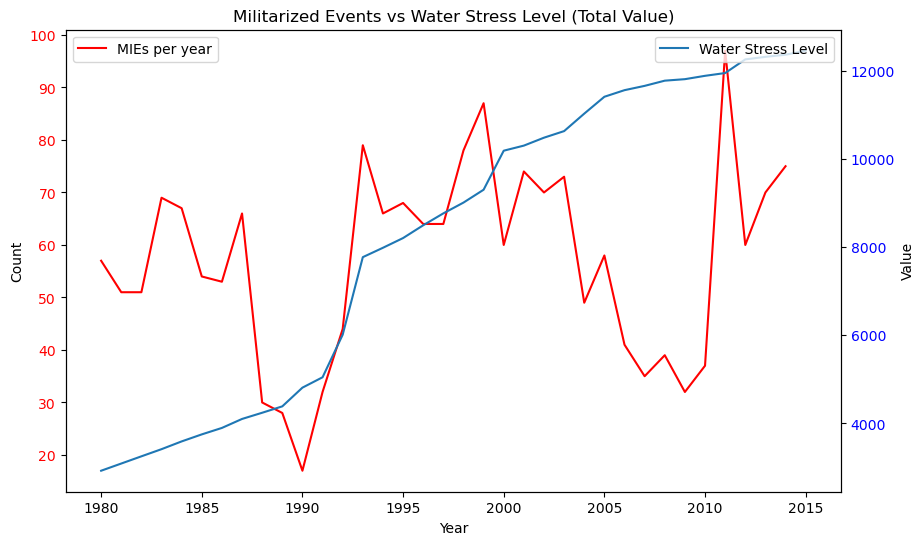

In [65]:
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=total_conflicts_per_year_df, x='Year', y='Total_Conflicts', label='MIEs per year', color="red")
plt.title('MIEs from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=total_value_per_year, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Militarized Events vs Water Stress Level (Total Value)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.savefig('militarized_events_vs_water_stress_by_year(total_value).png', bbox_inches='tight') 
plt.show()

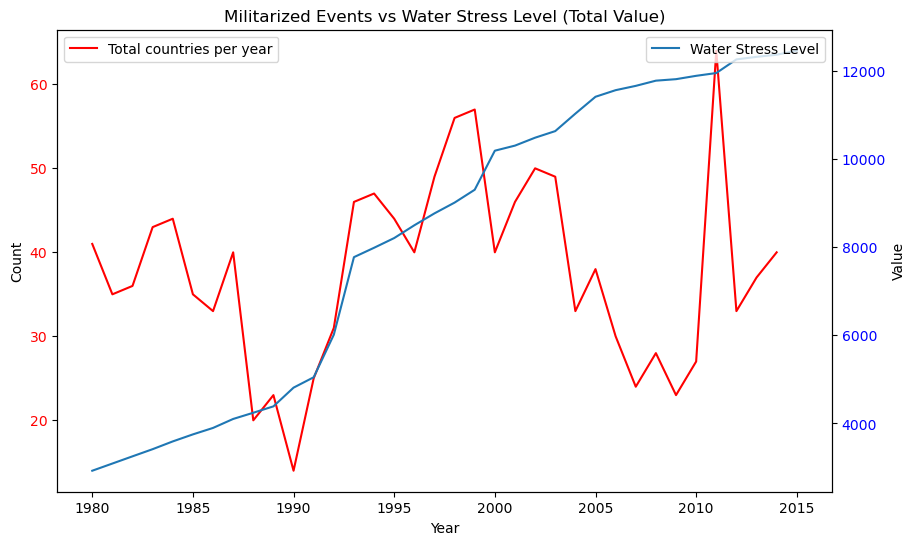

In [66]:
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=no_of_countries_by_year_df, x='Year', y='Number_of_Countries_in_Conflict', label='Total countries per year', color="red")
plt.title('Total Countries in conflict per year from 1980-2015')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count') 
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

sns.lineplot(data=total_value_per_year, x='Year', y='Value', label='Water Stress Level')
plt.xlabel('Year')
ax2.set_ylabel('Value')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('Militarized Events vs Water Stress Level (Total Value)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.savefig('militarized_events_vs_water_stress_by_year(total_value).png', bbox_inches='tight') 
plt.show()

### Create columns for all variables in the export and create a new dataframe with new column values

In [67]:
# Create dataframe for Human Capital Index (max value = 1)
hdi_df = aqua_csv.loc[aqua_csv['Variable'] == 'Human Development Index (HDI)']
hdi_df = hdi_df.rename(columns={'Value': 'HDI'}).drop(columns=['Variable', 'Unit'])

In [68]:
# Create dataframe for Pop Density (ppl/km2)
pop_dens_df = aqua_csv.loc[aqua_csv['Variable'] == 'Population density']
pop_dens_df = pop_dens_df.rename(columns={'Value': 'Pop Density'}).drop(columns=['Variable', 'Unit'])

In [69]:
# Create dataframe for Wtr Stress %
wstress_df = aqua_csv.loc[aqua_csv['Variable'] == 'SDG 6.4.2. Water Stress']
wstress_df = wstress_df.rename(columns={'Value': 'Wtr Stress'}).drop(columns=['Variable', 'Unit'])

In [70]:
# Create dataframe for Total exploitable water resources (1b m3/yr)
tw_res_df = aqua_csv.loc[aqua_csv['Variable'] == 'Total exploitable water resources']
tw_res_df = tw_res_df.rename(columns={'Value': 'Tot Wtr Resource'}).drop(columns=['Variable', 'Unit'])

In [71]:
# Create dataframe for Total freshwater withdrawal 1b m3/yr)
tfw_wdrl_df = aqua_csv.loc[aqua_csv['Variable'] == 'Total freshwater withdrawal']
tfw_wdrl_df = tfw_wdrl_df.rename(columns={'Value': 'FreshW Wdrl'}).drop(columns=['Variable', 'Unit'])

In [72]:
# Create dataframe for Total Population (1000ppl)
tpop_df = aqua_csv.loc[aqua_csv['Variable'] == 'Total population']
tpop_df = tpop_df.rename(columns={'Value': 'Total Population'}).drop(columns=['Variable', 'Unit'])

In [73]:
# Create dataframe for Total Water Withdrawl (ppl/km2)
twdrl_df = aqua_csv.loc[aqua_csv['Variable'] == 'Total water withdrawal']
twdrl_df = twdrl_df.rename(columns={'Value': 'Total Withdrawl'}).drop(columns=['Variable', 'Unit'])

In [74]:
# Create dataframe for Total water withdrawal per capita (m3/ppl/yr)
tw_wdrl_pc_df = aqua_csv.loc[aqua_csv['Variable'] == 'Total water withdrawal per capita']
tw_wdrl_pc_df = tw_wdrl_pc_df.rename(columns={'Value': 'Wtr Withdrawl'}).drop(columns=['Variable', 'Unit'])

In [75]:
# Make a list of dataframes
#aqua_df_lst = [hdi_df, pop_dens_df, wstress_df, tw_res_df, tfw_wdrl_df, tpop_df, twdrl_df, tw_wdrl_pc_df]

# Create a clean dataframe for water data 
#aqua_df_clean = reduce(lambda left,right: pd.merge(left,right,on=['Year', 'Country'],how='outer'), aqua_df_lst)

# Display the clean dataframe
#aqua_df_clean.head()

MergeError: Passing 'suffixes' which cause duplicate columns {'VariableGroup_x', 'Symbol_x', 'IsAggregate_x', 'Subgroup_x'} is not allowed.

## Conflict plotting

## Freedom Levels

### Create Chart comparing the Freedom Level of Countries each year

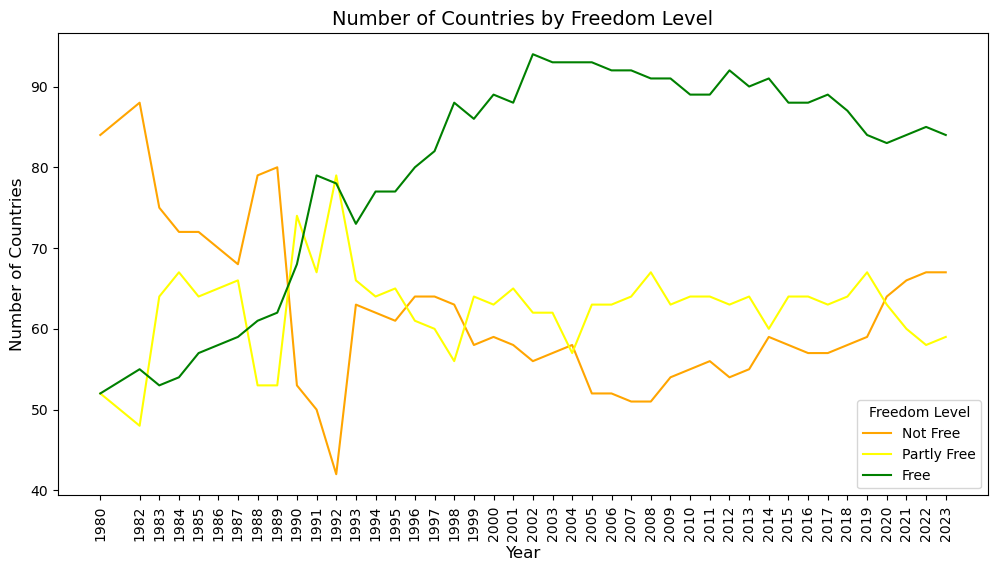

In [76]:
# Define the mapping from numbers to words
freedom_level_mapping = {
    0: 'Not Free',
    1: 'Partly Free',
    2: 'Free',
}

color_mapping = {
    'Not Free': 'orange',
    'Partly Free': 'yellow',
    'Free': 'green'
}

# Filter the DataFrame to include only data from the year 1980 onwards
regimes_df_filtered = regimes_df[regimes_df['Year'] >= 1980]

# Group by 'Year' and 'Freedom Level' and count occurrences
freedom_counts = regimes_df_filtered.groupby(['Year', 'Freedom Level']).size().reset_index(name='Count')

# Pivot the data for easier plotting
pivot_df = freedom_counts.pivot(index='Year', columns='Freedom Level', values='Count').fillna(0)

# Rename the columns using the mapping
pivot_df.columns = pivot_df.columns.map(freedom_level_mapping)

# Plotting
plt.figure(figsize=(12, 6))

# Plot lines for each Freedom Level
for freedom_level in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[freedom_level], label=freedom_level, color=color_mapping[freedom_level])

# Customizing the plot
plt.title('Number of Countries by Freedom Level', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Countries', fontsize=12)
plt.xticks(pivot_df.index, rotation=90)
plt.legend(title='Freedom Level')
plt.show()


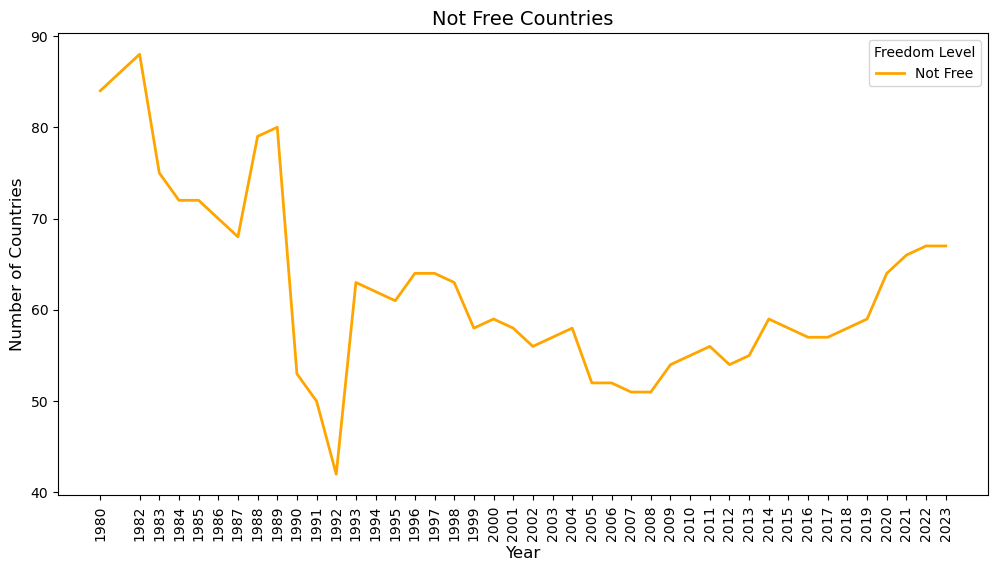

In [77]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot only the "Not Free" line
plt.plot(pivot_df.index, pivot_df['Not Free'], label='Not Free', linewidth=2, color='orange')

# Customizing the plot
plt.title('Not Free Countries', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Countries', fontsize=12)
plt.xticks(pivot_df.index, rotation=90)
plt.legend(title='Freedom Level')

# Display the plot
plt.show()


### Chart Comparing Number of "Not Free" Countries with Milatirized Events

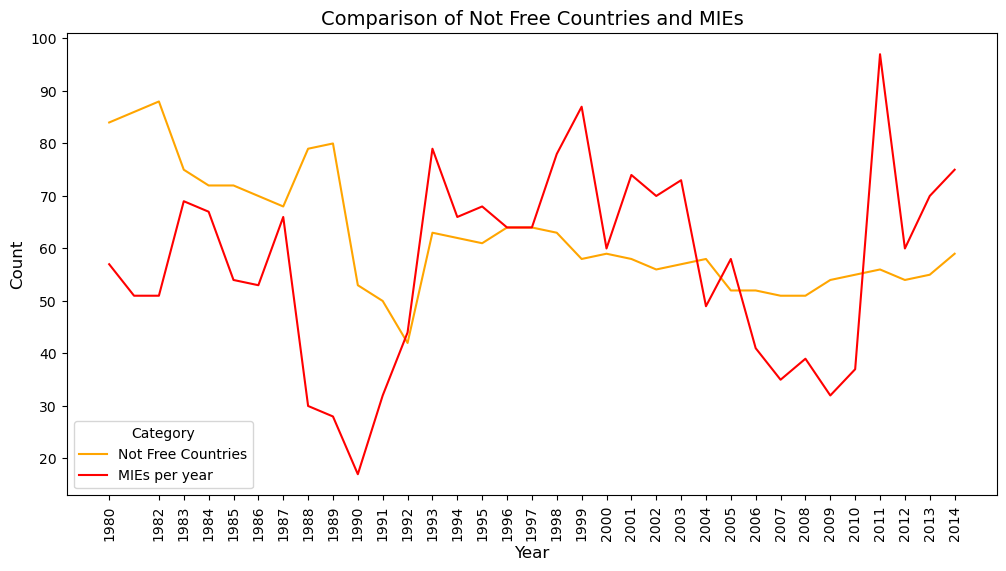

In [78]:
# Filter the data for the year range 1980 to 2015
pivot_df_filtered = pivot_df[pivot_df.index <= 2014]
total_conflicts_per_year_df_filtered = total_conflicts_per_year_df[total_conflicts_per_year_df['Year'] <= 2014]

plt.figure(figsize=(12, 6))

# Plot the "Not Free" line
plt.plot(pivot_df_filtered.index, pivot_df_filtered['Not Free'], label='Not Free Countries', color='orange')

# Plot the "MIEs per year" line
sns.lineplot(data=total_conflicts_per_year_df_filtered, x='Year', y='Total_Conflicts', label='MIEs per year', color='red', )

# Customizing the plot
plt.title('Comparison of Not Free Countries and MIEs', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(pivot_df_filtered.index, rotation=90)
plt.legend(title='Category')

# Display the plot
plt.show()


### Chart Comparing Number of "Not Free" Countries with Water Stress Levels

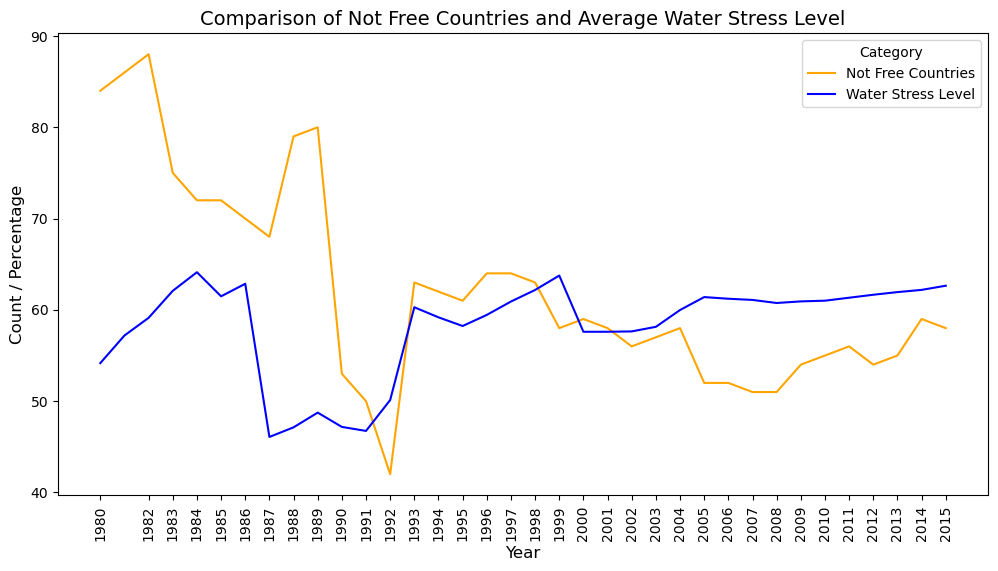

In [79]:
# Filter the data for the year range 1980 to 2015
pivot_df_filtered = pivot_df[pivot_df.index <= 2015]
overall_percentage_per_year_filtered = overall_percentage_per_year[overall_percentage_per_year['Year'] <= 2015]

# Plotting
plt.figure(figsize=(12, 6))

# Plot the "Not Free" line
plt.plot(pivot_df_filtered.index, pivot_df_filtered['Not Free'], label='Not Free Countries', color='orange')

# Plot the "Water Stress Level" line
sns.lineplot(data=overall_percentage_per_year_filtered, x='Year', y='Value', label='Water Stress Level', color='blue', )

# Customizing the plot
plt.title('Comparison of Not Free Countries and Average Water Stress Level', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count / Percentage', fontsize=12)
plt.xticks(pivot_df_filtered.index, rotation=90)
plt.legend(title='Category')

# Display the plot
plt.show()


### Statistical Analysis of Not Free Country Data

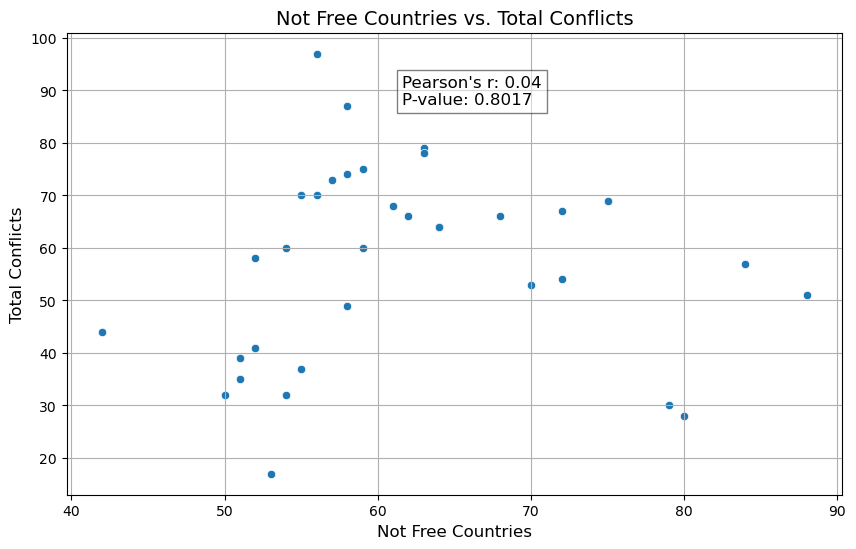

In [80]:
# Correlation between Not Free Countries and Total Conflicts
# Align the datasets on the same years
notfree_mie_merged_df = pivot_df_filtered.merge(total_conflicts_per_year_df_filtered, left_index=True, right_on='Year')
not_free_values = notfree_mie_merged_df['Not Free']
total_conflicts_values = notfree_mie_merged_df['Total_Conflicts']

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=not_free_values, y=total_conflicts_values)

# Customizing the scatter plot
plt.title('Not Free Countries vs. Total Conflicts', fontsize=14)
plt.xlabel('Not Free Countries', fontsize=12)
plt.ylabel('Total Conflicts', fontsize=12)
plt.grid(True)

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(not_free_values, total_conflicts_values)

# Display Pearson's r and p-value on the plot
plt.text(x=max(not_free_values)*0.7, y=max(total_conflicts_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Display the plot
plt.show()


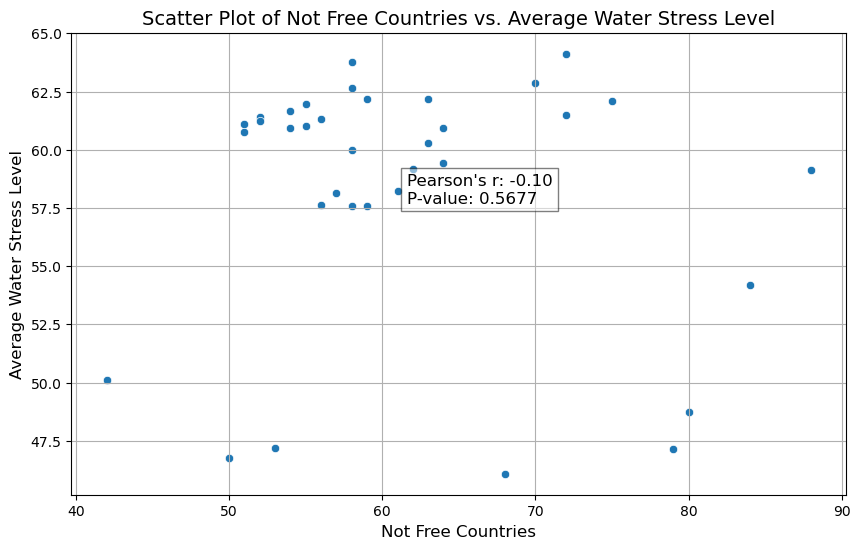

In [81]:
# Correlation between Not Free Countries and Total Conflicts

# Align the datasets on the same years
notfree_wtrstress_merged_df = pivot_df_filtered.merge(overall_percentage_per_year_filtered, left_index=True, right_on='Year')
not_free_values = notfree_wtrstress_merged_df['Not Free']
water_stress_values = notfree_wtrstress_merged_df['Value']

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=not_free_values, y=water_stress_values)

# Customizing the scatter plot
plt.title('Scatter Plot of Not Free Countries vs. Average Water Stress Level', fontsize=14)
plt.xlabel('Not Free Countries', fontsize=12)
plt.ylabel('Average Water Stress Level', fontsize=12)
plt.grid(True)

# Calculate Pearson's r
correlation_coefficient, p_value = pearsonr(not_free_values, water_stress_values)

# Display Pearson's r and p-value on the plot
plt.text(x=max(not_free_values)*0.7, y=max(water_stress_values)*0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Display the plot
plt.show()


### Written Analysis of Freedom Level of Countries when compared to number of conflicts and average water stress level.

Since 1980, the number of countries that are considered "Free" by "Our World in Data" has drastically increased, where in 1980 there were over 80 "Not Free" countries and just over 50 "Free" countries, but now there are over 80 Free countries and less than 70 Not Free and Partly Free countries.

The levels are defined as follows:
-Free countries are understood as countries in which citizens have many political rights (free and fair elections, political pluralism and participation, functioning government) and civil liberties (freedoms of expression and association, rule of law, personal autonomy).
-Partly free country are countries in which citizens have some political rights and civil liberties.
-Not free country are countries in which citizens have few political rights and civil liberties.

For this project, I was especially interested to find out if there is a correlation between the changes in the number of Not Free countries and the number of conflicts, as well as the Water Stress Levels. 
When the Not Free countries are compared to the number of Milatirzed Events per year, there seems to be some similarities. However, in the statisical analysis, Pearson's r for this correlation was 0.04, and the p-value was 0.8017, indicating that there is a weak positive correlation between the Not Free Country and Total Conflict variables, and any correlation that is present has a high probability of occurring by random chance.
The comparison between Not Free Countries and Average Water Stress level also seems to have a correlation, however Pearson's r was -0.09, indicating even less correlation between the two, and a p-value of 0.6017 also indicates that the weak correlation probably occurred by random chance.


## Per Capita Income Levels

### Create Chart showing the Per Capita income levels

C:\Users\Chris\AppData\Local\Temp\ipykernel_27500\2437222571.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = per_capita_df.groupby(['Year', 'Income Bin']).size().unstack(fill_value=0)


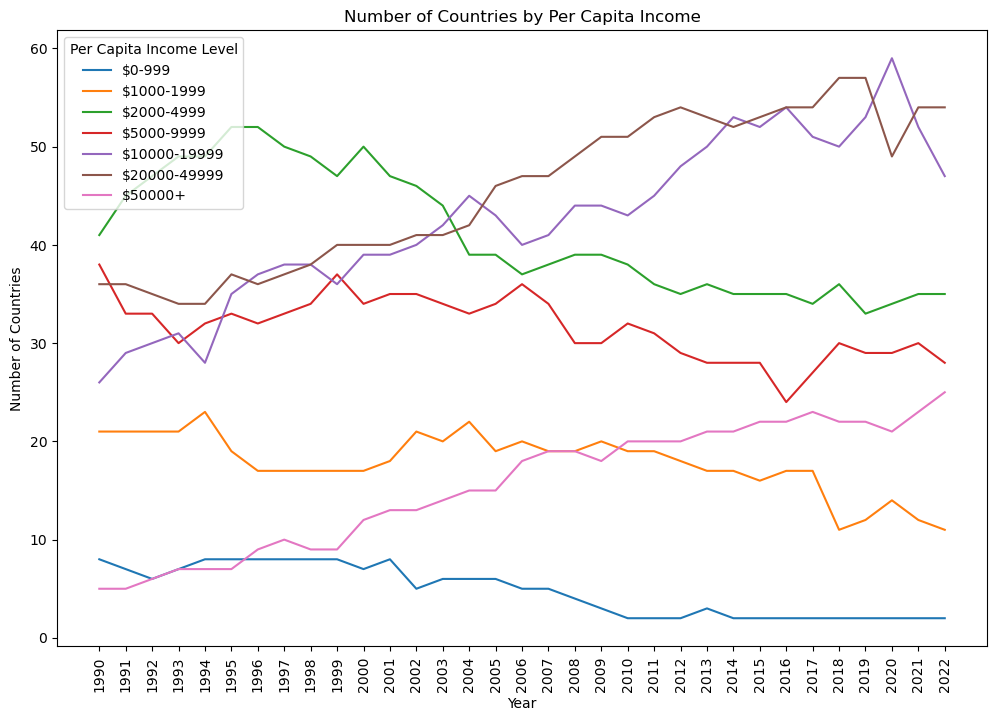

In [82]:
# Create the bins and labels
bins = [0, 999, 1999, 4999, 9999, 19999, 49999, float('inf')]
labels = ['$0-999', '$1000-1999', '$2000-4999', '$5000-9999', '$10000-19999', '$20000-49999', '$50000+']

# Create a new column for binned income
per_capita_df['Income Bin'] = pd.cut(per_capita_df['Per Capita Income'], bins=bins, labels=labels)

# Group by Year and Income Bin, then count the number of countries in each bin
grouped = per_capita_df.groupby(['Year', 'Income Bin']).size().unstack(fill_value=0)

# Plot the line chart
plt.figure(figsize=(12, 8))

# Iterate over each column (Income Bin) and plot
for column in grouped.columns:
    plt.plot(grouped.index, grouped[column], label=column)

plt.title('Number of Countries by Per Capita Income')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.legend(title='Per Capita Income Level')
plt.xticks(grouped.index, rotation = 90)
plt.show()


### Per Capita vs. MIE

C:\Users\Chris\AppData\Local\Temp\ipykernel_27500\296220025.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conflicts_by_income_bin = merged_df.groupby(['Year', 'Income Bin'])['Number_of_Conflicts'].sum().unstack(fill_value=0)


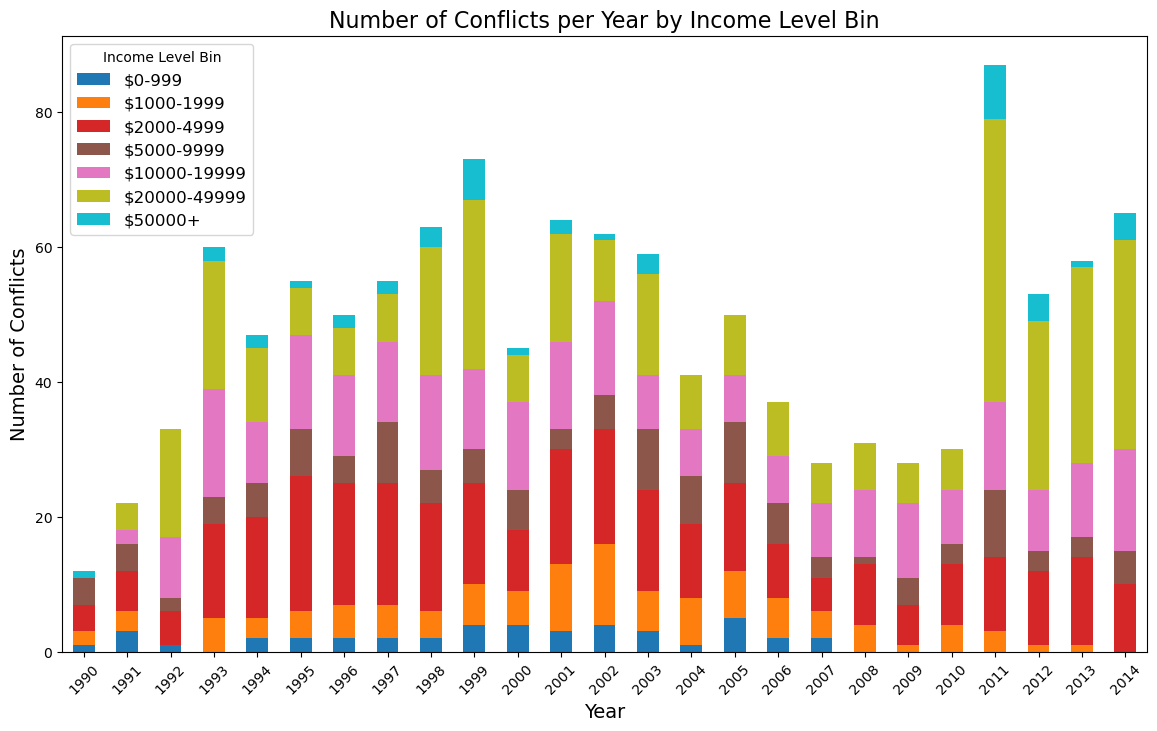

In [83]:
# Create the bins and labels for income
bins = [0, 999, 1999, 4999, 9999, 19999, 49999, float('inf')]
labels = ['$0-999', '$1000-1999', '$2000-4999', '$5000-9999', '$10000-19999', '$20000-49999', '$50000+']

# Create a new column for binned income
per_capita_df['Income Bin'] = pd.cut(per_capita_df['Per Capita Income'], bins=bins, labels=labels)

# Merge the datasets on Year and Country
merged_df = pd.merge(per_capita_df, mie_per_year_df, on=['Year', 'Country'])

# Group by Year and Income Bin, then sum the number of conflicts in each bin
conflicts_by_income_bin = merged_df.groupby(['Year', 'Income Bin'])['Number_of_Conflicts'].sum().unstack(fill_value=0)

# Plotting the bar chart
plt.figure(figsize=(14, 8))

# Plotting bars for each income bin stacked on top of each other
conflicts_by_income_bin.plot(kind='bar', stacked=True, colormap='tab10', ax=plt.gca())

# Customizing the plot
plt.title('Number of Conflicts per Year by Income Level Bin', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Conflicts', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Income Level Bin', fontsize=12)

# Display the plot
plt.show()


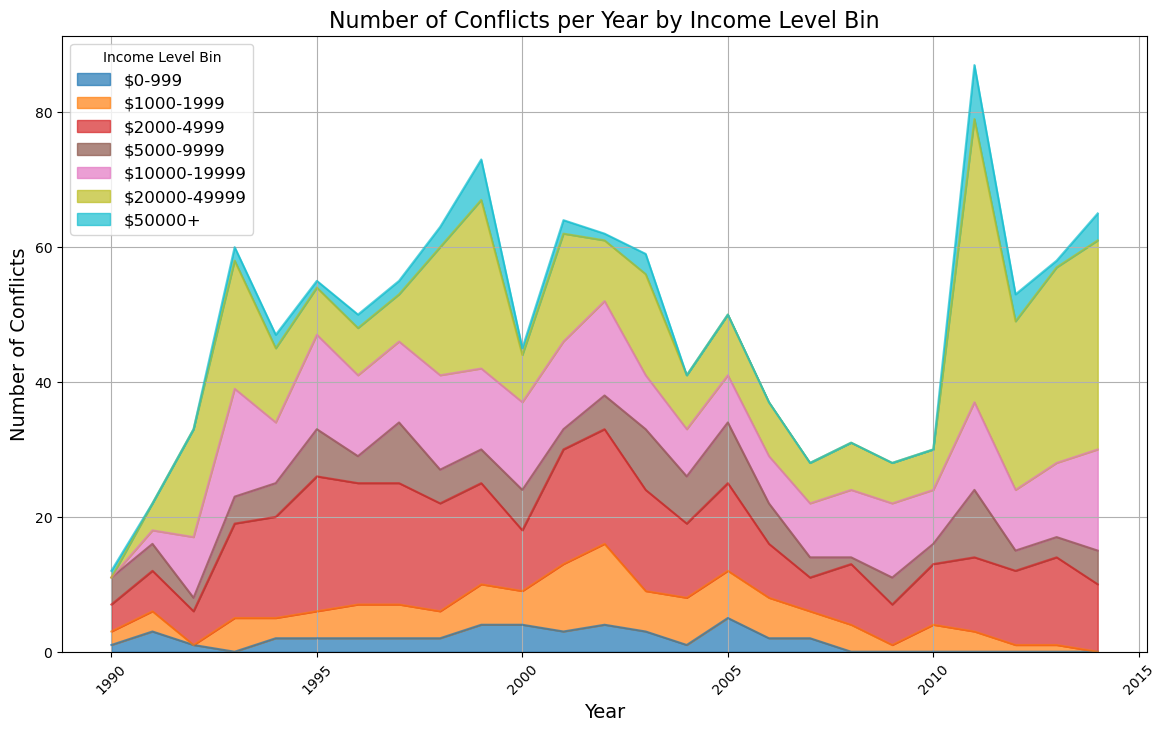

In [84]:
plt.figure(figsize=(14, 8))
conflicts_by_income_bin.plot(kind='area', stacked=True, colormap='tab10', alpha=0.7, ax=plt.gca())

plt.title('Number of Conflicts per Year by Income Level Bin', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Conflicts', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Income Level Bin', fontsize=12)
plt.grid(True)

plt.show()

C:\Users\Chris\AppData\Local\Temp\ipykernel_27500\2990024452.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conflicts_by_income_bin = merged_df.groupby('Income Bin')['Number_of_Conflicts'].sum()


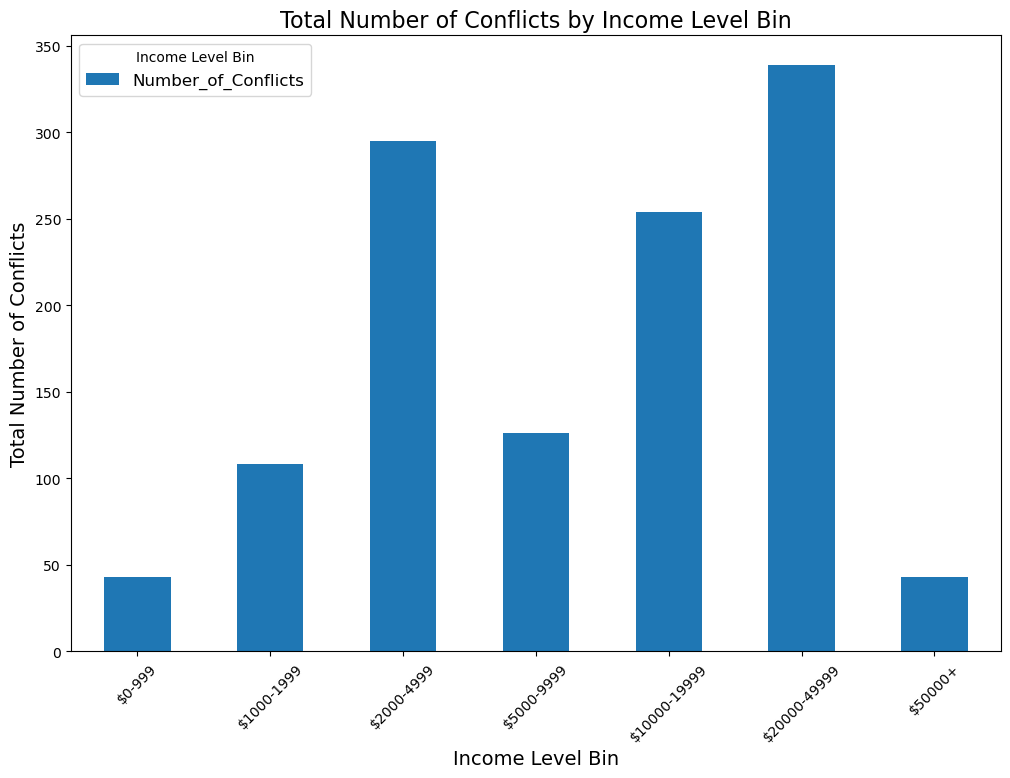

In [85]:
# Define income bins and labels
bins = [0, 999, 1999, 4999, 9999, 19999, 49999, float('inf')]
labels = ['$0-999', '$1000-1999', '$2000-4999', '$5000-9999', '$10000-19999', '$20000-49999', '$50000+']

# Create a new column for income bin in per_capita_df
per_capita_df['Income Bin'] = pd.cut(per_capita_df['Per Capita Income'], bins=bins, labels=labels)

# Merge the per_capita_df with mie_per_year_df
merged_df = pd.merge(per_capita_df, mie_per_year_df, on=['Year', 'Country'])

# Group by Income Bin and sum the number of conflicts
conflicts_by_income_bin = merged_df.groupby('Income Bin')['Number_of_Conflicts'].sum()

# Plotting the bar chart
plt.figure(figsize=(12, 8))

# Plot bars for each income bin
conflicts_by_income_bin.plot(kind='bar', colormap='tab10', ax=plt.gca())

# Customizing the plot
plt.title('Total Number of Conflicts by Income Level Bin', fontsize=16)
plt.xlabel('Income Level Bin', fontsize=14)
plt.ylabel('Total Number of Conflicts', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Income Level Bin', fontsize=12)

# Display the plot
plt.show()


### Statistical analysis of number of conflicts in income level bins

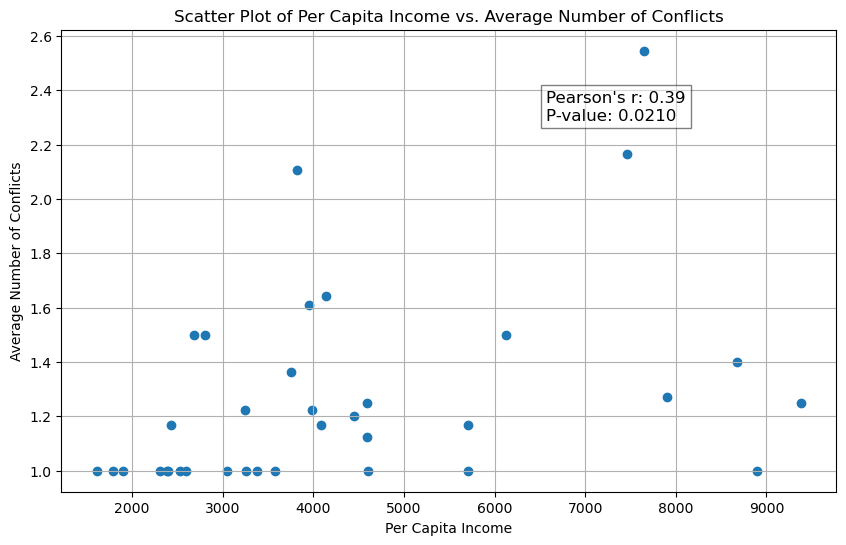

Pearson's r: 0.39
P-value: 0.0210


In [86]:
# Define income bins and labels
bins = [0, 999, 1999, 4999, 9999, 19999, 49999, float('inf')]
labels = ['$0-999', '$1000-1999', '$2000-4999', '$5000-9999', '$10000-19999', '$20000-49999', '$50000+']

# Create a new column for income bin in per_capita_df
per_capita_df['Income Bin'] = pd.cut(per_capita_df['Per Capita Income'], bins=bins, labels=labels)

# Merge the per_capita_df with mie_per_year_df
merged_df = pd.merge(per_capita_df, mie_per_year_df, on=['Year', 'Country'])

# Filter data for the '$2000-4999' income bin
bin_data = merged_df[merged_df['Income Bin'] == '$2000-4999']

# Calculate the average number of conflicts per year for each country in the bin
conflicts_per_country = bin_data.groupby('Country')['Number_of_Conflicts'].mean()

# Merge this data with per capita income for these countries
income_per_country = per_capita_df[per_capita_df['Country'].isin(conflicts_per_country.index)]
income_per_country = income_per_country.groupby('Country')['Per Capita Income'].mean()

# Merge the conflicts and income data
combined_df = pd.DataFrame({
    'Per Capita Income': income_per_country,
    'Average Number of Conflicts': conflicts_per_country
})

# Calculate Pearson's correlation coefficient
correlation_coefficient, p_value = pearsonr(combined_df['Per Capita Income'], combined_df['Average Number of Conflicts'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['Per Capita Income'], combined_df['Average Number of Conflicts'])
plt.title('Scatter Plot of Per Capita Income vs. Average Number of Conflicts')
plt.xlabel('Per Capita Income')
plt.ylabel('Average Number of Conflicts')
plt.grid(True)

# Display Pearson's r and p-value on the plot
plt.text(x=max(combined_df['Per Capita Income']) * 0.7, 
         y=max(combined_df['Average Number of Conflicts']) * 0.9,
         s=f"Pearson's r: {correlation_coefficient:.2f}\nP-value: {p_value:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Show the plot
plt.show()

# Display correlation results
print(f"Pearson's r: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.4f}")


### Analysis

"Our World in Data" split the countries of the world into 7 groups by Per Capita Income. Most countries in the world fall into the $2000-$49999 Per Capita Income range. 
Countries in the $2000-$50000 Per Capita Income range experienced higher levels of conflict than the other income bins. 

We wanted to see if there was any correlation between being in a specific income level and experiencing higher levels of conflicts.  
The statistical analysis showed with a Pearson's r of 0.39 that the correlation between these two variables is moderate to strong, meaning countries in the $2000-4999 bin are more likely to experience conflict. The p-value of 0.0210 shows that the observed correlation is statistically significant. 


In [89]:
per_capita_df

,Country,Year,Per Capita Income,Income Bin
0,Afghanistan,2002,1280.4631,$1000-1999
1,Afghanistan,2003,1292.3335,$1000-1999
2,Afghanistan,2004,1260.0605,$1000-1999
3,Afghanistan,2005,1352.3207,$1000-1999
4,Afghanistan,2006,1366.9932,$1000-1999
...,...,...,...,...
6557,Zimbabwe,2018,2399.6216,$2000-4999
6558,Zimbabwe,2019,2203.3967,$2000-4999
6559,Zimbabwe,2020,1990.3195,$1000-1999
6560,Zimbabwe,2021,2115.1445,$2000-4999


In [90]:
filtered_water_by_year_df

,Country,Year,Value,Unit
24129,Afghanistan,1980,46.223790,%
52739,Afghanistan,1981,49.691010,%
52740,Afghanistan,1982,53.158230,%
52741,Afghanistan,1983,56.625450,%
52742,Afghanistan,1984,60.092670,%
...,...,...,...,...
59201,Zimbabwe,2011,32.696677,%
59202,Zimbabwe,2012,32.488030,%
59203,Zimbabwe,2013,32.282670,%
59204,Zimbabwe,2014,32.077309,%


In [91]:
# Merge the income and water stress datasets on Year and Country
capita_stress_merged_df = pd.merge(per_capita_df, filtered_water_by_year_df, on=['Year', 'Country'])

capita_stress_merged_df.head(75)

,Country,Year,Per Capita Income,Income Bin,Value,Unit
0,Afghanistan,2002,1280.4631,$1000-1999,54.757019,%
1,Afghanistan,2003,1292.3335,$1000-1999,54.757019,%
2,Afghanistan,2004,1260.0605,$1000-1999,54.757019,%
3,Afghanistan,2005,1352.3207,$1000-1999,54.757019,%
4,Afghanistan,2006,1366.9932,$1000-1999,54.757019,%
...,...,...,...,...,...,...
70,Angola,1994,3728.8862,$2000-4999,1.502306,%
71,Angola,1995,4149.4460,$2000-4999,1.535034,%
72,Angola,1996,4557.1480,$2000-4999,1.567762,%
73,Angola,1997,4728.2925,$2000-4999,1.600490,%


In [92]:
# Group by Year and Income Bin, then calculate the average water stress percentage
water_stress_by_income_bin = capita_stress_merged_df.groupby(['Year', 'Income Bin'])['Value'].mean().unstack()

water_stress_by_income_bin

C:\Users\Chris\AppData\Local\Temp\ipykernel_27500\339831343.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  water_stress_by_income_bin = capita_stress_merged_df.groupby(['Year', 'Income Bin'])['Value'].mean().unstack()


Income Bin,$0-999,$1000-1999,$2000-4999,$5000-9999,$10000-19999,$20000-49999,$50000+
Year,,,,,,,
1990,2.388211,9.942580,23.940104,32.428414,25.914238,42.784160,347.862734
1991,2.181195,9.662747,24.471534,30.935230,24.816637,45.092207,355.873623
1992,2.916303,9.191433,23.402764,31.290021,22.910279,74.786691,363.884513
1993,2.779625,9.305764,26.447800,29.205385,23.977610,71.375396,662.638771
1994,4.403032,11.478398,39.260948,30.453054,22.125084,72.891666,608.693523
1995,3.971600,9.381561,36.078194,29.863166,21.241388,73.540320,637.232649
1996,4.165746,10.332035,33.223684,31.836820,20.637890,68.897420,502.615369
1997,4.359739,10.510110,32.485286,33.901199,19.781216,70.623401,537.231188
1998,4.553870,10.046180,32.534262,33.889020,19.752066,80.134955,627.987258


### Per Capita vs. Water Stress

C:\Users\Chris\AppData\Local\Temp\ipykernel_27500\521516359.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  water_stress_by_income_bin = capita_stress_merged_df.groupby(['Year', 'Income Bin'])['Value'].mean().unstack()


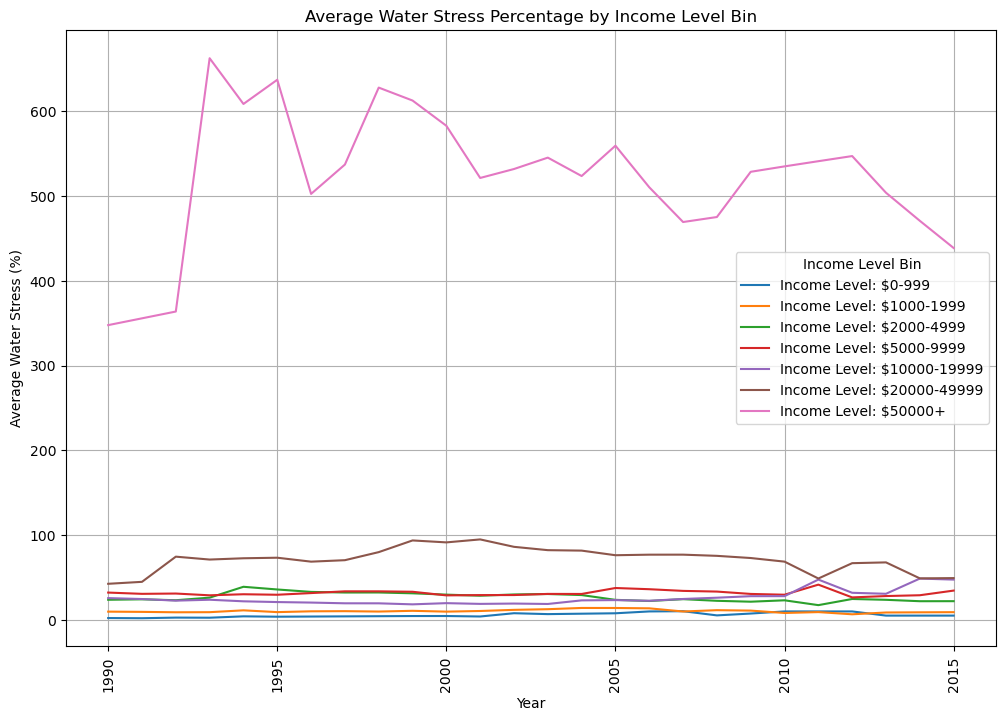

In [93]:
# Group by Year and Income Bin, then calculate the average water stress percentage
water_stress_by_income_bin = capita_stress_merged_df.groupby(['Year', 'Income Bin'])['Value'].mean().unstack()

# Plot the average water stress percentage for each income bin over time
plt.figure(figsize=(12, 8))

# Iterate over each column (Income Bin) and plot
for column in water_stress_by_income_bin.columns:
    plt.plot(water_stress_by_income_bin.index, water_stress_by_income_bin[column], label=f"Income Level: {column}")

plt.title('Average Water Stress Percentage by Income Level Bin')
plt.xlabel('Year')
plt.ylabel('Average Water Stress (%)')
plt.legend(title='Income Level Bin')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()
